In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt

import warnings

In [2]:
# Constants

cancer_file = "hw4_data/breast-cancer_scale"
cancer_train_indices_file = "hw4_data/breast-cancer_train_indices.txt"
cancer_test_indices_file = "hw4_data/breast-cancer_test_indices.txt"


sonar_file = "hw4_data/sonar_scale"
sonar_train_indices_file = "hw4_data/sonar_train_indices.txt"
sonar_test_indices_file = "hw4_data/sonar_test_indices.txt"


covtype_file = "hw4_data/covtype.data"
covtype_train_indices_file = "hw4_data/covtype_train_indices.txt"
covtype_test_indices_file = "hw4_data/covtype_test_indices.txt"


k = 5
Cs = [0.1, 1, 10, 100, 1000]
loss = "squared_hinge"
penalty = "l2"

## Load data

In [35]:
def load_data(data_file, train_idx_file, test_idx_file):
    """
    Load train and test data from data_file
    Returns:
        X_train, Y_train, X_test, Y_test
    """

    # Load data
    def conv(item):
        return item.split(":")[1] if ":" in item else item

    data = np.loadtxt(data_file, converters=conv)
    print(f"\n Data shape: {data.shape}")

    # Load index
    train_idx = np.loadtxt(train_idx_file, dtype="int", delimiter=",")
    test_idx = np.loadtxt(test_idx_file, dtype="int", delimiter=",")

    X_train, Y_train = data[train_idx, 1:], data[train_idx, 0]
    X_test, Y_test = data[test_idx, 1:], data[test_idx, 0]

    print(f"\nX_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}, Y_train shape: {Y_test.shape}\n")
    return X_train, Y_train, X_test, Y_test

In [36]:
# Load sonar file

def load_sonar_file():
    data_file = 'hw4_data/sonar_scale'
    print(f"\nLoading: {data_file}")

    X_list = []
    y_list = []
    max_feature = 0

    with open(data_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue

            y_list.append(int(float(parts[0])))

            features = {}
            for item in parts[1:]:
                idx, val = item.split(':')
                idx = int(idx) - 1
                features[idx] = float(val)
                max_feature = max(max_feature, idx)
            X_list.append(features)

    # Convert to arrays
    n_samples = len(y_list)
    n_features = max_feature + 1
    X = np.zeros((n_samples, n_features))
    for i, features in enumerate(X_list):
        for idx, val in features.items():
            X[i, idx] = val
    y = np.array(y_list)

    train_idx = np.loadtxt('hw4_data/sonar_train_indices.txt', dtype=int, delimiter=',')
    test_idx = np.loadtxt('hw4_data/sonar_test_indices.txt', dtype=int, delimiter=',')

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    return X_train, y_train, X_test, y_test



In [3]:
def load_covtype(filename, file_indices_train, file_indices_test):
    data = np.loadtxt(filename, delimiter=",")
    X = data[:, :-1]
    Y =data[:, -1]

    train_indices = np.loadtxt(file_indices_train, dtype="int", delimiter=",")
    test_indices = np.loadtxt(file_indices_test, dtype="int", delimiter=",")

    X_train, Y_train = X[train_indices, :], Y[train_indices]
    X_test, Y_test = X[test_indices, :], Y[test_indices]

    print("Load files:")
    print(f"\t{filename}\n\t{file_indices_train}\n\t{file_indices_test}")
    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    return X_train, Y_train, X_test, Y_test

## Support Vector Classifier class

In [37]:
class SupportVectorClassifier:
    def __init__(self, loss: str= 'hinge',
                 penalty: str = 'l2',
                 kernel: str = 'linear',
                 max_iter: int = 1000):

        self.loss = loss
        self.penalty = penalty
        self.kernel = kernel
        self.max_iter = max_iter


    def create_model(self, C):
        model = None
        if self.kernel == "linear":
            model = LinearSVC(penalty=self.penalty, loss=self.loss, C=C, max_iter=self.max_iter)
        else:
            model = SVC(kernel=self.kernel, C=C, max_iter=self.max_iter)

        return model


    def kfold_cross_validation(self, X_train, Y_train, k, Cs):
        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        val_error = []
        train_error = []

        for C in Cs:
            v_errors = []
            t_errors = []

            for train_idx, val_idx in kfold.split(X_train):
                X_train_split = X_train[train_idx, :]
                X_val_split = X_train[val_idx, :]
                Y_train_split = Y_train[train_idx]
                Y_val_split = Y_train[val_idx]

                # Create model
                classifier = self.create_model(C)

                # Train model
                classifier.fit(X_train_split, Y_train_split)

                # Evaluate
                t_errors.append(1 - classifier.score(X_train_split, Y_train_split))
                v_errors.append(1 - classifier.score(X_val_split, Y_val_split))

            train_error.append(np.mean(t_errors))
            val_error.append(np.mean(v_errors))

        best_C = Cs[np.argmin(val_error)]
        return train_error, val_error, best_C


    def train(self, X_train, Y_train, model):
        model.fit(X_train, Y_train)
        error_rate = 1 - model.score(X_train, Y_train)
        return model, error_rate


    def test(self, X_test, Y_test, model):
        error_rate = 1 - model.score(X_test, Y_test)
        return error_rate

# SVM

#### Breast Cancer Data

In [38]:
kernels = ["linear", "poly", "rbf"]

In [39]:
# Linear SVM, Polynomial Kernel and RBF Kernel

warnings.filterwarnings("ignore")

X_train, Y_train, X_test, Y_test = load_data(cancer_file, cancer_train_indices_file, cancer_test_indices_file)
best_Cs = {}

for kernel in kernels:
    model = SupportVectorClassifier(loss=loss, penalty=penalty, kernel=kernel)
    train_error, val_error, best_C = model.kfold_cross_validation(X_train, Y_train, k, Cs)
    best_Cs[kernel] = best_C

    df = pd.DataFrame({"C": Cs,
                    "Train error": np.round(train_error, 4),
                    "Val error": np.round(val_error, 4)})

    print(f"Breast Cancer Data with SVC kernel = {kernel}")
    print(df)
    print(f"Best C is {best_C}\n")


 Data shape: (683, 11)

X_train shape: (546, 10), Y_train shape: (546,)
X_test shape: (137, 10), Y_train shape: (137,)

Breast Cancer Data with SVC kernel = linear
        C  Train error  Val error
0     0.1       0.0279     0.0347
1     1.0       0.0279     0.0347
2    10.0       0.0279     0.0329
3   100.0       0.0284     0.0347
4  1000.0       0.0284     0.0347
Best C is 10

Breast Cancer Data with SVC kernel = poly
        C  Train error  Val error
0     0.1       0.0275     0.0293
1     1.0       0.0211     0.0366
2    10.0       0.0078     0.0585
3   100.0       0.0000     0.0769
4  1000.0       0.0000     0.0769
Best C is 0.1

Breast Cancer Data with SVC kernel = rbf
        C  Train error  Val error
0     0.1       0.0293     0.0293
1     1.0       0.0220     0.0348
2    10.0       0.0101     0.0439
3   100.0       0.0000     0.0677
4  1000.0       0.0000     0.0677
Best C is 0.1



##### Eval with best C

In [40]:
for kernel in kernels:
    svc = SupportVectorClassifier(loss=loss, penalty=penalty, kernel=kernel)
    model = svc.create_model(best_Cs[kernel])
    model, train_err = svc.train(X_train, Y_train, model)

    error_test_rate = svc.test(X_test, Y_test, model)
    print(f"Data Breast Cancer with kernel SVC = {kernel}")
    print(f"Best C: {best_C}")
    print(f"Train error: {round(train_err, 4)}")
    print(f"Test error rate: {round(error_test_rate, 4)}\n")

Data Breast Cancer with kernel SVC = linear
Best C: 0.1
Train error: 0.0275
Test error rate: 0.0438

Data Breast Cancer with kernel SVC = poly
Best C: 0.1
Train error: 0.0275
Test error rate: 0.0219

Data Breast Cancer with kernel SVC = rbf
Best C: 0.1
Train error: 0.0293
Test error rate: 0.0365



### Sonar data

In [41]:
X_train, Y_train, X_test, Y_test = load_sonar_file()
best_Cs = {}

for kernel in kernels:
    model = SupportVectorClassifier(loss=loss, penalty=penalty, kernel=kernel)
    train_error, val_error, best_C = model.kfold_cross_validation(X_train, Y_train, k, Cs)
    best_Cs[kernel] = best_C

    df = pd.DataFrame({"C": Cs,
                    "Train error": np.round(train_error, 4),
                    "Val error": np.round(val_error, 4)})

    print(f"Sonar Data with SVC kernel {kernel}")
    print(df)
    print(f"Best C is {best_C}\n")


Loading: hw4_data/sonar_scale
Sonar Data with SVC kernel linear
        C  Train error  Val error
0     0.1       0.0979     0.3071
1     1.0       0.0287     0.3130
2    10.0       0.0000     0.2531
3   100.0       0.0000     0.2533
4  1000.0       0.0000     0.2533
Best C is 10

Sonar Data with SVC kernel poly
        C  Train error  Val error
0     0.1       0.2349     0.3011
1     1.0       0.0120     0.1745
2    10.0       0.0000     0.1684
3   100.0       0.0000     0.1684
4  1000.0       0.0000     0.1684
Best C is 10

Sonar Data with SVC kernel rbf
        C  Train error  Val error
0     0.1       0.3902     0.4693
1     1.0       0.0512     0.1504
2    10.0       0.0000     0.1622
3   100.0       0.0000     0.1622
4  1000.0       0.0000     0.1622
Best C is 1



##### Eval with best C

In [42]:
for kernel in kernels:
    svc = SupportVectorClassifier(loss=loss, penalty=penalty, kernel=kernel)
    model = svc.create_model(best_Cs[kernel])
    model, train_err = svc.train(X_train, Y_train, model)

    error_test_rate = svc.test(X_test, Y_test, model)
    print(f"Data Sonar with kernel SVC = {kernel}")
    print(f"Best C: {best_Cs[kernel]}")
    print(f"Train error: {round(train_err, 4)}")
    print(f"Test error rate: {round(error_test_rate, 4)}\n")

Data Sonar with kernel SVC = linear
Best C: 10
Train error: 0.006
Test error rate: 0.1667

Data Sonar with kernel SVC = poly
Best C: 10
Train error: 0.0
Test error rate: 0.0952

Data Sonar with kernel SVC = rbf
Best C: 1
Train error: 0.0482
Test error rate: 0.1429



# Data Preprocessing

In [6]:
methods = ["rescale", "standardization", "normalization"]

In [7]:
def data_preprocessing(X, method:str):
    if method == "normalization":
        X_normalized = preprocessing.normalize(X, norm="l2", axis=1)
        return X_normalized

    if method == "rescale":
        minmax_scaler = preprocessing.MinMaxScaler() # default range (0, 1)
        X_scaled = minmax_scaler.fit_transform(X)
        return X_scaled

    if method == "standardization":
        standard_scaler = preprocessing.StandardScaler()
        X_standardized = standard_scaler.fit_transform(X=X)
        return X_standardized

    print("No available data preprocessing method!")

##### Evaluation

In [16]:
def evaluate(X_test, Y_test, model):
    Y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(Y_test, Y_pred)
    f1score = metrics.f1_score(Y_test, Y_pred, pos_label=2)
    y_score = model.decision_function(X_test)
    auc = metrics.roc_auc_score(Y_test, y_score)

    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_score, pos_label=2)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1score:.4f}")
    print(f"AUC: {auc:.4f}\n")
    return acc, f1score, auc, fpr, tpr

### Raw data

In [28]:
fprs = {}
tprs = {}

In [ ]:
X_train, Y_train, X_test, Y_test = load_covtype(covtype_file, covtype_train_indices_file, covtype_test_indices_file)
Y_train[Y_train != 2] = -1
Y_test[Y_test != 2] = -1

linearsvc = SupportVectorClassifier(loss=loss, penalty=penalty, kernel="linear")

# 5-fold cross validation
train_err_raw, val_err_raw, best_C_raw = linearsvc.kfold_cross_validation(X_train, Y_train, k, Cs)
df = pd.DataFrame({"C": Cs,
                    "Train error": train_err_raw,
                    "Val error": val_err_raw})
print(f"\nCover Data with SVC kernel linear")
print(df)
print(f"Best C is {best_C_raw}\n")

# Train with best C on all training data
linearsvc = SupportVectorClassifier(loss=loss, penalty=penalty, kernel="linear")
model_raw = linearsvc.create_model(best_C_raw)
model_raw, train_err = linearsvc.train(X_train, Y_train, model_raw)

# Evaluation
error_test_rate = linearsvc.test(X_test, Y_test, model_raw)
print("Data Cover Evaluation")
print(f"Best C: {best_C_raw}")
print(f"Train error: {round(train_err, 4)}")
print(f"Test error rate: {round(error_test_rate, 4)}")

acc, f1score, auc, fpr, tpr = evaluate(X_test, Y_test, model_raw)
fprs["raw"] = fpr
tprs["raw"] = tpr


Load files:
	hw4_data/covtype.data
	hw4_data/covtype_train_indices.txt
	hw4_data/covtype_test_indices.txt
X shape: (581012, 54)
Y shape: (581012,)

Cover Data with SVC kernel linear
        C  Train error  Val error
0     0.1     0.244951   0.244864
1     1.0     0.245188   0.245318
2    10.0     0.244718   0.244692
3   100.0     0.245310   0.245210
4  1000.0     0.244835   0.244728
Best C is 10

Data Cover Evaluation
Best C: 10
Train error: 0.2451
Test error rate: 0.2457
Accuracy: 0.7543
F1-score: 0.7533
AUC: 0.8230



### Preprocessed data

In [ ]:
X_train, Y_train, X_test, Y_test = load_covtype(covtype_file, covtype_train_indices_file, covtype_test_indices_file)
Y_train[Y_train != 2] = -1
Y_test[Y_test != 2] = -1

for method in methods:
    X_train_preprocessed = data_preprocessing(X_train, method)
    X_test_preprocessed = data_preprocessing(X_test, method)


    linearsvc = SupportVectorClassifier(loss=loss, penalty=penalty, kernel="linear")

    # 5-fold cross validation
    train_err, val_err, best_C = linearsvc.kfold_cross_validation(X_train_preprocessed, Y_train, k, Cs)

    print(f"\nPreprocessed Cover data Linear SVM {method}")
    df = pd.DataFrame({"C": Cs,
                        "Train error": train_err,
                        "Val error": val_err})
    print(df)
    print(f"Best C is {best_C}\n")

    # Train with best C on all training data
    linearsvc = SupportVectorClassifier(loss=loss, penalty=penalty, kernel="linear")
    model = linearsvc.create_model(best_C)
    model, train_err = linearsvc.train(X_train_preprocessed, Y_train, model)

    # Evaluation
    error_test_rate = linearsvc.test(X_test_preprocessed, Y_test, model)
    print("Data Cover Evaluation")
    print(f"Best C: {best_C}")
    print(f"Train error: {round(train_err, 4)}")
    print(f"Test error rate: {round(error_test_rate, 4)}\n")
    acc, f1score, auc, fpr, tpr = evaluate(X_test_preprocessed, Y_test, model)
    fprs[method] = fpr
    tprs[method] = tpr

Load files:
	hw4_data/covtype.data
	hw4_data/covtype_train_indices.txt
	hw4_data/covtype_test_indices.txt
X shape: (581012, 54)
Y shape: (581012,)

Preprocessed Cover data Linear SVM rescale
        C  Train error  Val error
0     0.1     0.243075   0.243113
1     1.0     0.243114   0.243072
2    10.0     0.243106   0.243091
3   100.0     0.243107   0.243093
4  1000.0     0.243106   0.243096
Best C is 1

Data Cover Evaluation
Best C: 1
Train error: 0.2431
Test error rate: 0.2444

Accuracy: 0.7556
F1-score: 0.7546
AUC: 0.8246


Preprocessed Cover data Linear SVM standardization
        C  Train error  Val error
0     0.1     0.243107   0.243100
1     1.0     0.243109   0.243093
2    10.0     0.243108   0.243093
3   100.0     0.243108   0.243093
4  1000.0     0.243108   0.243093
Best C is 1

Data Cover Evaluation
Best C: 1
Train error: 0.2431
Test error rate: 0.2442

Accuracy: 0.7558
F1-score: 0.7542
AUC: 0.8247


Preprocessed Cover data Linear SVM normalization
        C  Train error  V

##### Plot ROC curves

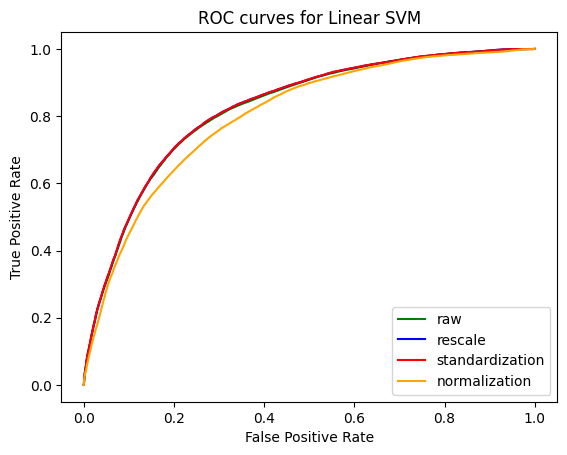

In [34]:
colors = ["green", "blue", "red", "orange"]
for (method, fpr), color in zip(fprs.items(), colors):
  tpr = tprs[method]
  plt.plot(fpr, tpr, color=color, label=method)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC curves for Linear SVM");